# Progressive RandomForestRegressor

In [1]:
import pandas
import sklearn
import scipy
from sklearn import model_selection, linear_model, preprocessing, metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy import cluster
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
rxns_df_x = pandas.read_csv("godineau2023_reactions_OHE1.csv")
rxns_df_x = rxns_df_x.drop('Unnamed: 0', axis=1)
rxns_df_y = pandas.read_csv("godineau2023_yields_OHE.csv")
rxns_df_y = rxns_df_y.drop('Unnamed: 0', axis=1)

In [9]:
def combine_one_hot(shap_values, name, mask, return_original=True):
    """  shap_values: an Explanation object
          name: name of new feature
          mask: bool array same lenght as features

         This function assumes that shap_values[:, mask] make up a one-hot-encoded feature
    """
    mask = np.array(mask)
    mask_col_names = np.array(shap_values.feature_names, dtype='object')[mask]

    sv_name = shap.Explanation(shap_values.values[:, mask],
                               feature_names=list(mask_col_names),
                               data=shap_values.data[:, mask],
                               base_values=shap_values.base_values,
                               display_data=shap_values.display_data,
                               instance_names=shap_values.instance_names,
                               output_names=shap_values.output_names,
                               output_indexes=shap_values.output_indexes,
                               lower_bounds=shap_values.lower_bounds,
                               upper_bounds=shap_values.upper_bounds,
                               main_effects=shap_values.main_effects,
                               hierarchical_values=shap_values.hierarchical_values,
                               clustering=shap_values.clustering,
                               )

    new_data = (sv_name.data * np.arange(sum(mask))).sum(axis=1).astype(int)

    svdata = np.concatenate([
        shap_values.data[:, ~mask],
        new_data.reshape(-1, 1)
    ], axis=1)

    if shap_values.display_data is None:
        svdd = shap_values.data[:, ~mask]
    else:
        svdd = shap_values.display_data[:, ~mask]

    svdisplay_data = np.concatenate([
        svdd,
        mask_col_names[new_data].reshape(-1, 1)
    ], axis=1)

    new_values = sv_name.values.sum(axis=1)
    svvalues = np.concatenate([
        shap_values.values[:, ~mask],
        new_values.reshape(-1, 1)
    ], axis=1)
    svfeature_names = list(np.array(shap_values.feature_names)[~mask]) + [name]

    sv = shap.Explanation(svvalues,
                          base_values=shap_values.base_values,
                          data=svdata,
                          display_data=svdisplay_data,
                          instance_names=shap_values.instance_names,
                          feature_names=svfeature_names,
                          output_names=shap_values.output_names,
                          output_indexes=shap_values.output_indexes,
                          lower_bounds=shap_values.lower_bounds,
                          upper_bounds=shap_values.upper_bounds,
                          main_effects=shap_values.main_effects,
                          hierarchical_values=shap_values.hierarchical_values,
                          clustering=shap_values.clustering,
                          )
    if return_original:
        return sv, sv_name
    else:
        return sv

rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv",sep='\t' )
rxns_df = rxns_df.drop('Yield of 3aa', axis=1)
rxns_df = rxns_df.drop('Round', axis=1)
rxns_df = rxns_df.drop('Conversion of 1a', axis=1)
rxns_df = rxns_df.drop('Acquisition type', axis=1)
def bool_feature(name):
    bool_list=[]
    for n in rxns_df_x.columns:
        if str(n) in list(set(rxns_df_x.columns.to_list()).intersection(set(rxns_df[f'{name}'].to_list()))):
            bool_list.append(True)
        else:
            bool_list.append(False)
    return np.array(bool_list)

## Round 0

In [3]:
rxns_df_x_0 = rxns_df_x.copy()
rxns_df_y_0 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_0)):
    if rxns_df_x_0['Round'][i] != 0:
        rxns_df_x_0 = rxns_df_x_0.drop([i], axis=0)
        rxns_df_y_0 = rxns_df_y_0.drop([i], axis=0)
rxns_df_x_0= rxns_df_x_0.drop('Round', axis=1)

In [6]:
x_train0, x_temp, y_train0, y_temp = train_test_split(rxns_df_x_0, rxns_df_y_0, test_size=0.2, random_state=42)
x_val0, x_test0, y_val0, y_test0 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [7]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train0, y_train0)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [8]:
#validation
y_val_pred0 = model.predict(x_val0)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val0, y_val_pred0)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val0, y_val_pred0)
RMSE_val = np.sqrt(mean_squared_error(y_val0, y_val_pred0))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred0 = model.predict(x_test0)
accuracy_test = r2_score(y_test0, y_test_pred0)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test0, y_test_pred0)
RMSE_test = np.sqrt(mean_squared_error(y_test0, y_test_pred0))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.0
Validation RMSE:0.6860488211490491
Validation MAE:0.67825
Test Set Accuracy with r2 : 0.9830184895848637
Test RMSE:1.2673049435711752
Test MAE:1.0629999999999853


The accuracy of the test set is MUCH higher than the accuracy of the validation set although it's the opposite for the MAE and RMSE.

Text(0.5, 0, 'Actual')

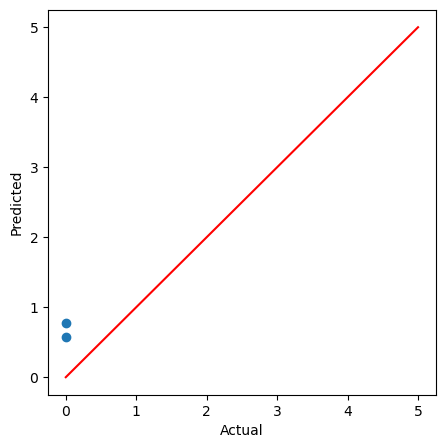

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(y_val0, y_val_pred0)
plt.plot([0,5], [0,5], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

Text(0.5, 0, 'Actual')

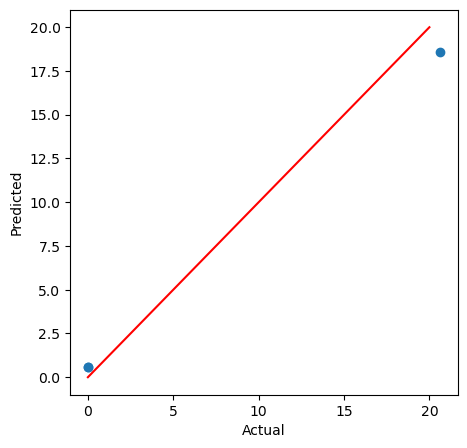

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(y_test0, y_test_pred0)
plt.plot([0,20], [0,20], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


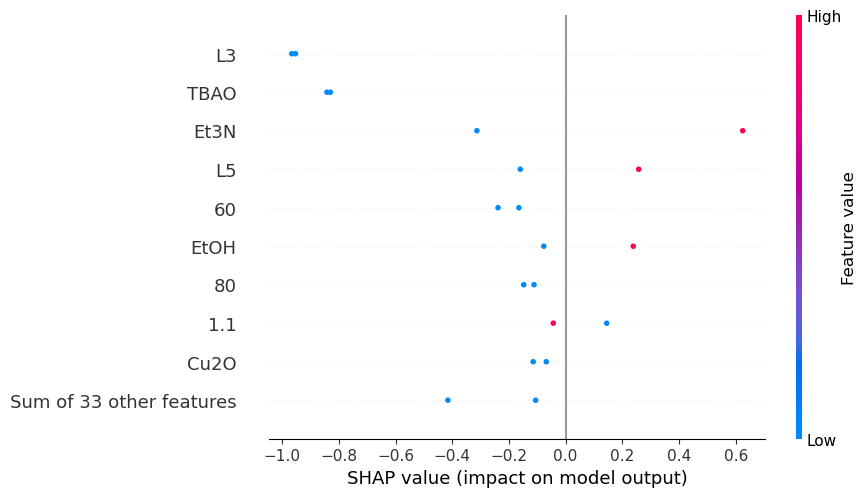

In [12]:
explainer = shap.Explainer(model, x_train0)
shap_values = explainer(x_val0, check_additivity=False)
shap.plots.beeswarm(shap_values)

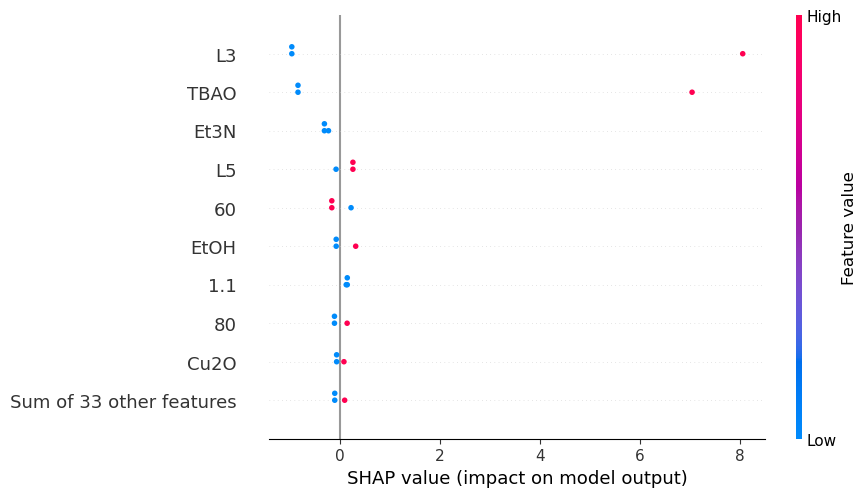

In [14]:
explainer = shap.Explainer(model, x_train0)
shap_values1 = explainer(x_test0, check_additivity=False)
shap.plots.beeswarm(shap_values1)

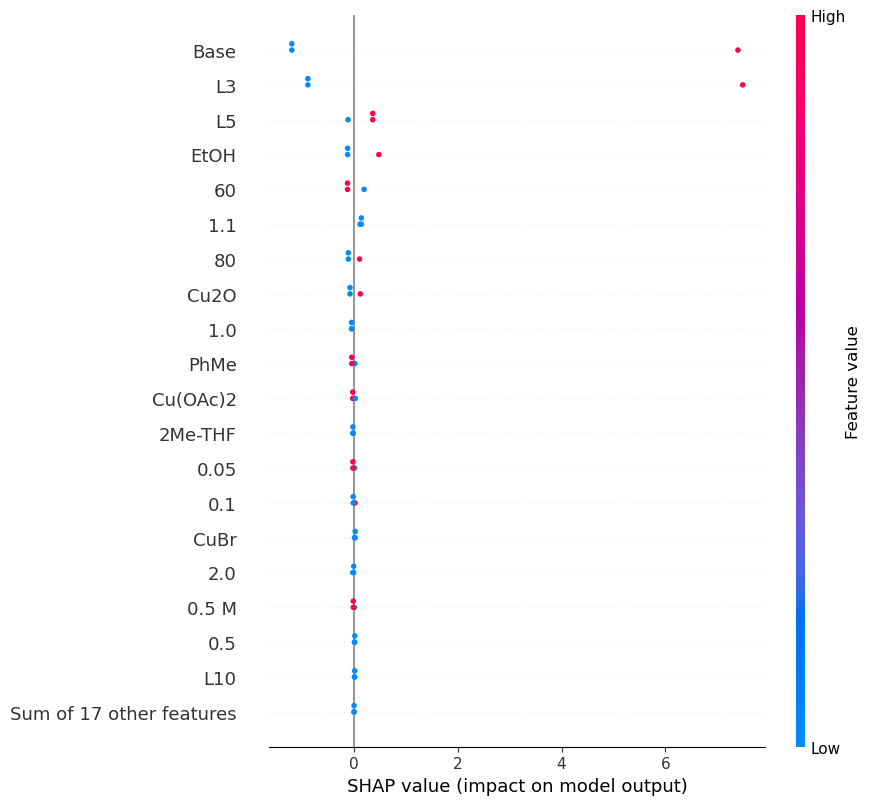

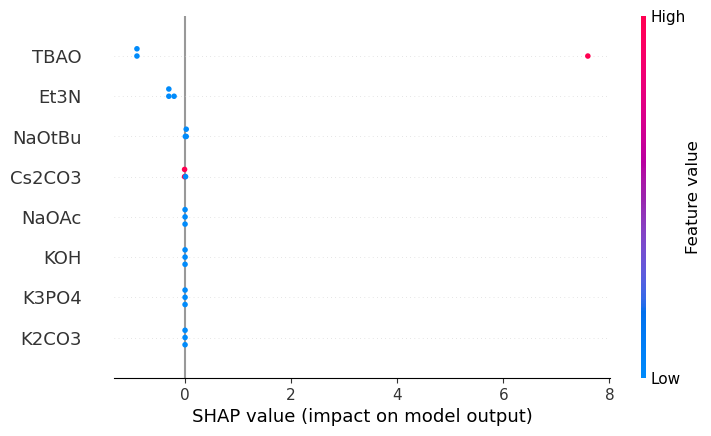

In [65]:
shap_values3,sv_occ = combine_one_hot(shap_values1, "Base", bool_feature('Base'))
shap.plots.beeswarm(shap_values3, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

There are 24 data points in the first set: it is very little, which explains why we cannot make much of these initial results. Specifically: there are too little test and validation points (2 validation points and 3 test points), so most features aren't even utilized and therefore their SHAPs are equal to 0. We need to look at more rounds to have more conclusive results.

## Round 0 + 1

In [15]:
rxns_df_x_1 = rxns_df_x.copy()
rxns_df_y_1 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_1)):
    if rxns_df_x_1['Round'][i] != 0:
        if rxns_df_x_1['Round'][i] != 1:
            rxns_df_x_1 = rxns_df_x_1.drop([i], axis=0)
            rxns_df_y_1 = rxns_df_y_1.drop([i], axis=0)
rxns_df_x_1= rxns_df_x_1.drop('Round', axis=1)

In [17]:
x_train1, x_temp, y_train1, y_temp = train_test_split(rxns_df_x_1, rxns_df_y_1, test_size=0.2, random_state=42)
x_val1, x_test1, y_val1, y_test1 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [18]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train1, y_train1)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [19]:
#validation
y_val_pred1 = model.predict(x_val1)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val1, y_val_pred1)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val1, y_val_pred1)
RMSE_val = np.sqrt(mean_squared_error(y_val1, y_val_pred1))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred1 = model.predict(x_test1)
accuracy_test = r2_score(y_test1, y_test_pred1)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test1, y_test_pred1)
RMSE_test = np.sqrt(mean_squared_error(y_test1, y_test_pred1))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.3432842631799905
Validation RMSE:9.456507469673971
Validation MAE:8.235919999999979
Test Set Accuracy with r2 : 0.9087262725908675
Test RMSE:2.789082046839057
Test MAE:2.0578800000000026


The validation accuracy has gone up while the test accuracy has diminished. All RMSE and MAE have also augmented.

Text(0.5, 0, 'Actual')

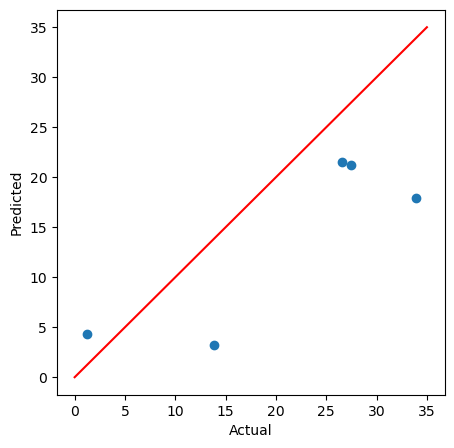

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(y_val1, y_val_pred1)
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

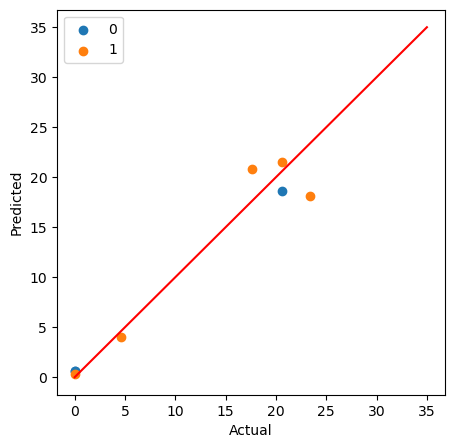

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(y_test0, y_test_pred0, label='0')
plt.scatter(y_test1, y_test_pred1, label='1')
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

The predictions made with this model on the data points from the previous round are more accurate.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


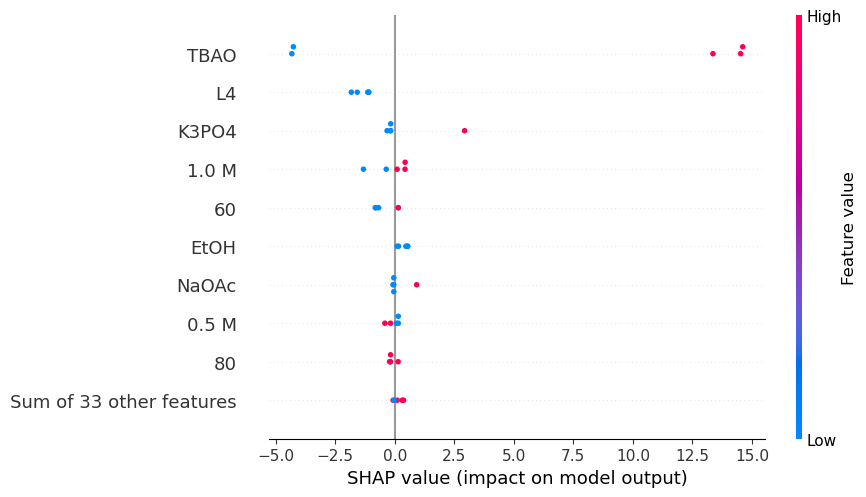

In [20]:
explainer = shap.Explainer(model, x_train1)
shap_values = explainer(x_val1, check_additivity=False)
shap.plots.beeswarm(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


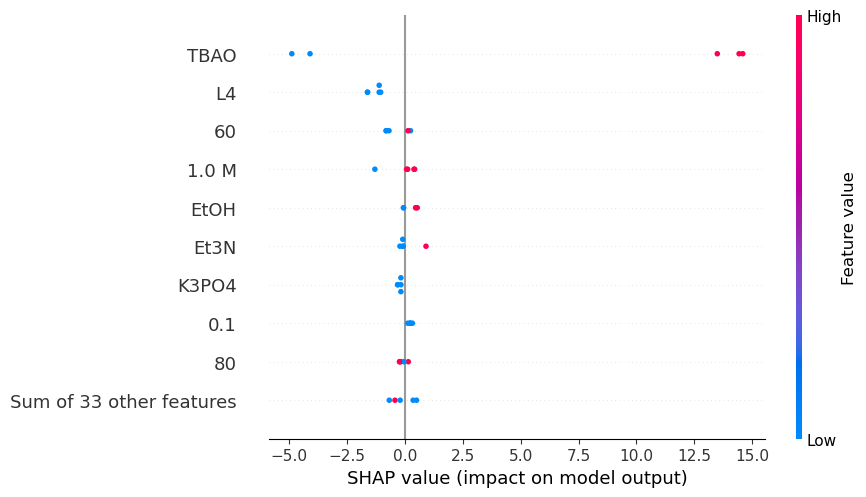

In [23]:
explainer = shap.Explainer(model, x_train1)
shap_values1 = explainer(x_test1, check_additivity=False)
shap.plots.beeswarm(shap_values1)

There are 48 data points in the combined rounds 0 and 1, which means the validation set and test set have 5 data points each. This is still not enough to include all the features. However we can already see that using TBAO as a base is beneficial to the yield--we had already established this in previous models.

## Round 0 + 1 + 2

In [25]:
rxns_df_x_2 = rxns_df_x.copy()
rxns_df_y_2 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_2)):
    if rxns_df_x_2['Round'][i] != 0:
        if rxns_df_x_2['Round'][i] != 1:
            if rxns_df_x_2['Round'][i] != 2:
                rxns_df_x_2 = rxns_df_x_2.drop([i], axis=0)
                rxns_df_y_2 = rxns_df_y_2.drop([i], axis=0)
rxns_df_x_2= rxns_df_x_2.drop('Round', axis=1)

In [26]:
x_train2, x_temp, y_train2, y_temp = train_test_split(rxns_df_x_2, rxns_df_y_2, test_size=0.2, random_state=42)
x_val2, x_test2, y_val2, y_test2 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [27]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train2, y_train2)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [28]:
#validation
y_val_pred2 = model.predict(x_val2)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val2, y_val_pred2)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val2, y_val_pred2)
RMSE_val = np.sqrt(mean_squared_error(y_val2, y_val_pred2))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred2 = model.predict(x_test2)
accuracy_test = r2_score(y_test2, y_test_pred2)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test2, y_test_pred2)
RMSE_test = np.sqrt(mean_squared_error(y_test2, y_test_pred2))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.6539420991044583
Validation RMSE:7.4705992907434835
Validation MAE:5.226514285714283
Test Set Accuracy with r2 : 0.783112793210553
Test RMSE:4.7611465457387485
Test MAE:3.433650000000002


The r2 has decreased for the test set and increased for the validation set, following the same tendance as previously. The RMSE and MAE have also augmented. This is mostly a result of an increase in the number of yields we are predicting.

Text(0.5, 0, 'Actual')

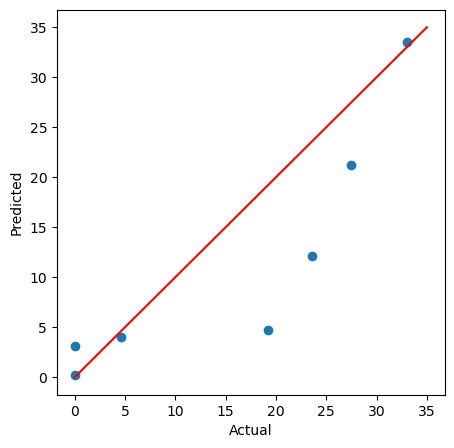

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(y_val2, y_val_pred2)
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

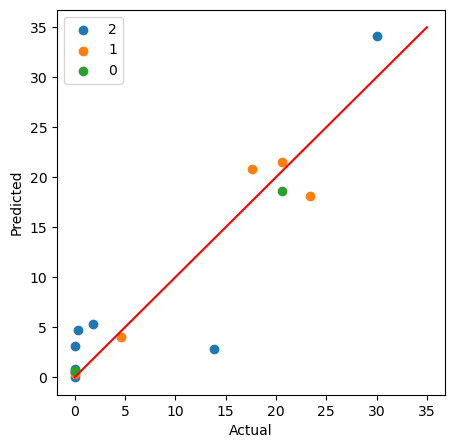

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

The predictions on this model seem to be less accurate than those of the previous two.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


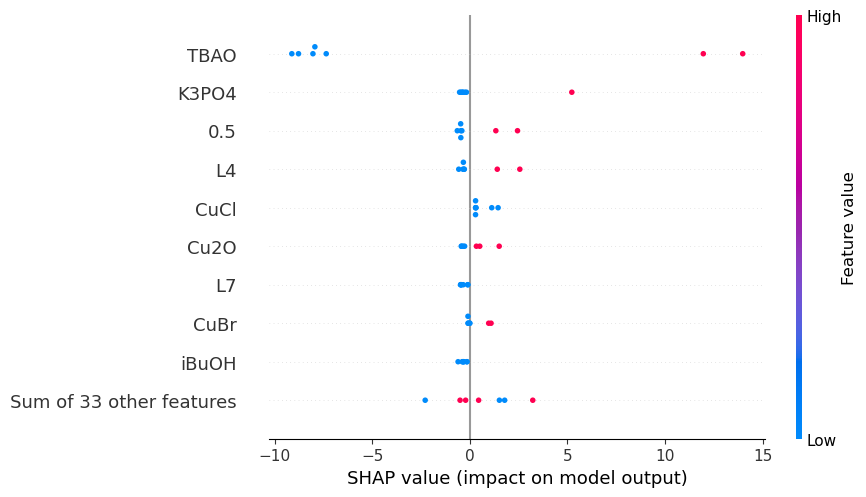

In [31]:
explainer = shap.Explainer(model, x_train2)
shap_values = explainer(x_val2, check_additivity=False)
shap.plots.beeswarm(shap_values)

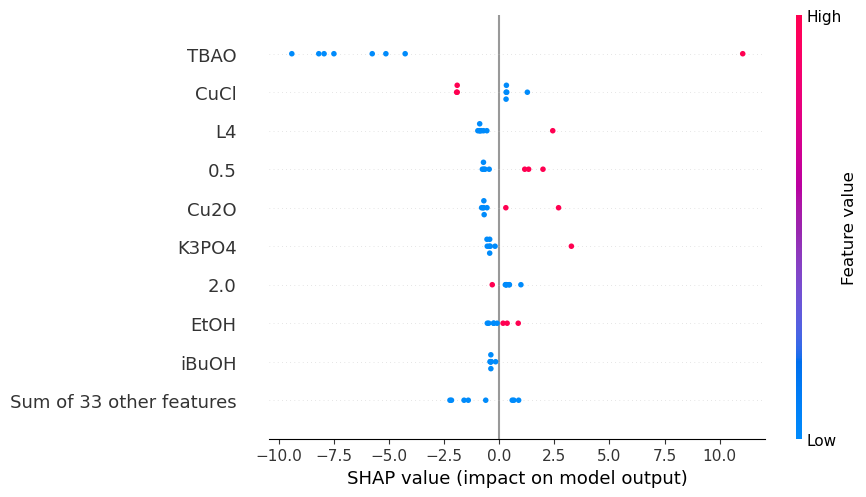

In [221]:
explainer = shap.Explainer(model, x_train2)
shap_values1 = explainer(x_test2, check_additivity=False)
shap.plots.beeswarm(shap_values1)

This set contains 72 points, which corresponds to 7 points in both the validation and test set. We can see that more features are starting to be identified as important such as the solvent EtOH and the Cu source Cu2O, though the base TBAO remains as (for now) the feature with the biggest SHAP value.

## Round 0 + 1 + 2 + 3

In [33]:
rxns_df_x_3 = rxns_df_x.copy()
rxns_df_y_3 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_3)):
    if rxns_df_x_3['Round'][i] != 0:
        if rxns_df_x_3['Round'][i] != 1:
            if rxns_df_x_3['Round'][i] != 2:
                if rxns_df_x_3['Round'][i] != 3:
                    rxns_df_x_3 = rxns_df_x_3.drop([i], axis=0)
                    rxns_df_y_3 = rxns_df_y_3.drop([i], axis=0)
rxns_df_x_3= rxns_df_x_3.drop('Round', axis=1)

In [35]:
x_train3, x_temp, y_train3, y_temp = train_test_split(rxns_df_x_3, rxns_df_y_3, test_size=0.2, random_state=42)
x_val3, x_test3, y_val3, y_test3 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [36]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train3, y_train3)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [37]:
#validation
y_val_pred3 = model.predict(x_val3)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val3, y_val_pred3)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val3, y_val_pred3)
RMSE_val = np.sqrt(mean_squared_error(y_val3, y_val_pred3))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred3 = model.predict(x_test3)
accuracy_test = r2_score(y_test3, y_test_pred3)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test3, y_test_pred3)
RMSE_test = np.sqrt(mean_squared_error(y_test3, y_test_pred3))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.5201442883005029
Validation RMSE:8.434612500464969
Validation MAE:5.006829999999991
Test Set Accuracy with r2 : 0.6175335090884609
Test RMSE:5.890020681203083
Test MAE:4.7142700000000035


The r2 has decreased for both values in this set, while the RMSE and MAE have increased. The accuracy of the last two models have decreased, which might be due to the introduction of new features gaining importance but not having enough iterations for the model to properly identify them just yet.

Text(0.5, 0, 'Actual')

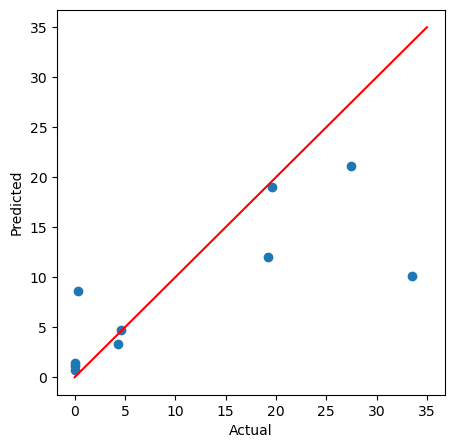

In [38]:
plt.figure(figsize=(5,5))
plt.scatter(y_val3, y_val_pred3)
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

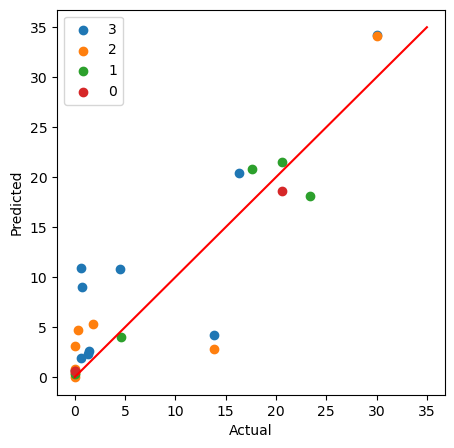

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

We can clearly see here that the predictions for this fourth model are generally less accurate than the previous ones.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


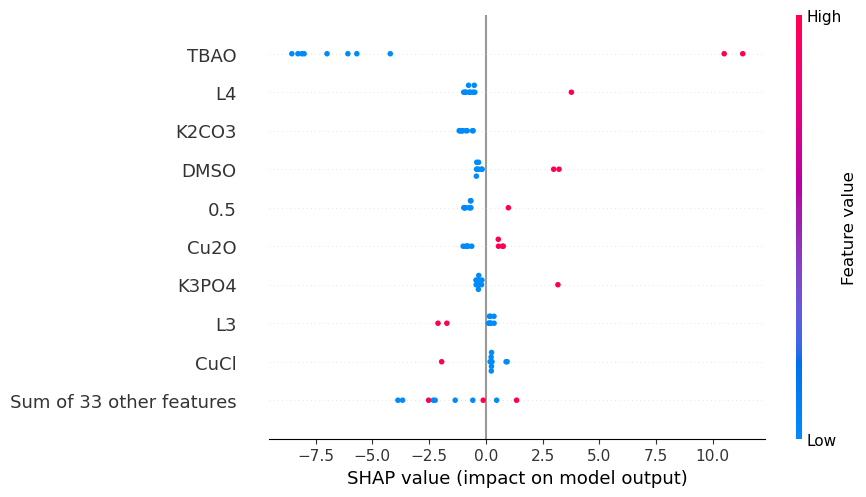

In [40]:
explainer = shap.Explainer(model, x_train3)
shap_values = explainer(x_val3, check_additivity=False)
shap.plots.beeswarm(shap_values)

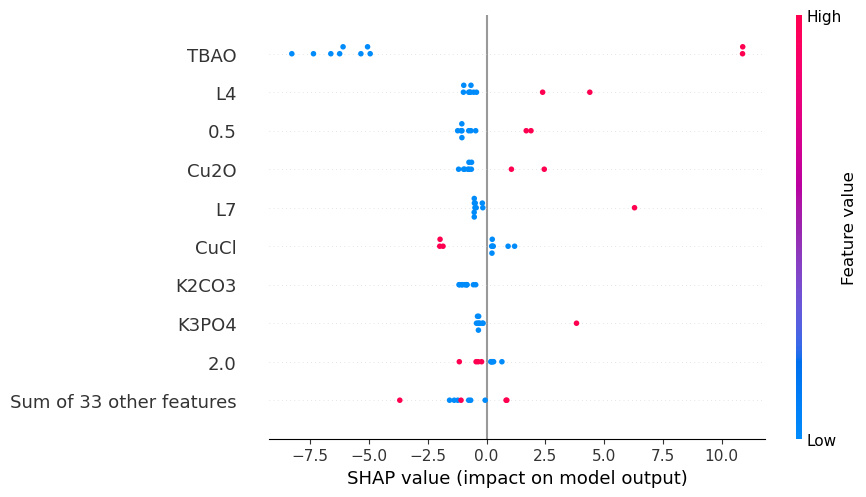

In [41]:
explainer = shap.Explainer(model, x_train3)
shap_values1 = explainer(x_test3, check_additivity=False)
shap.plots.beeswarm(shap_values1)

This set has 96 values, which corresponds to 10 points per validation and test set. The features with the highest SHAP values are mostly the same as the previous models, though we can now see the apparition of the K2CO3 base that we know is one of the most efficient. The model's precision is stalling, even degrading as it is introduced to new features that it doesn't have enough data about to estimate the precise effect of. Note that it is still missing a lot of key features we had seen as having a big influence in models using the entirere data. 

## Round 0 + 1 + 2 + 3 + 4

In [42]:
rxns_df_x_4 = rxns_df_x.copy()
rxns_df_y_4 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_4)):
    if rxns_df_x_4['Round'][i] != 0:
        if rxns_df_x_4['Round'][i] != 1:
            if rxns_df_x_4['Round'][i] != 2:
                if rxns_df_x_4['Round'][i] != 3:
                    if rxns_df_x_4['Round'][i] != 4:
                        rxns_df_x_4 = rxns_df_x_4.drop([i], axis=0)
                        rxns_df_y_4 = rxns_df_y_4.drop([i], axis=0)
rxns_df_x_4= rxns_df_x_4.drop('Round', axis=1)

In [43]:
x_train4, x_temp, y_train4, y_temp = train_test_split(rxns_df_x_4, rxns_df_y_4, test_size=0.2, random_state=42)
x_val4, x_test4, y_val4, y_test4 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [44]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train4, y_train4)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [45]:
#validation
y_val_pred4 = model.predict(x_val4)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val4, y_val_pred4)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val4, y_val_pred4)
RMSE_val = np.sqrt(mean_squared_error(y_val4, y_val_pred4))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred4 = model.predict(x_test4)
accuracy_test = r2_score(y_test4, y_test_pred4)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test4, y_test_pred4)
RMSE_test = np.sqrt(mean_squared_error(y_test4, y_test_pred4))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.5487131780210539
Validation RMSE:9.89180324827076
Validation MAE:8.014041666666664
Test Set Accuracy with r2 : 0.4941104162098482
Test RMSE:9.38309092716787
Test MAE:6.249591666666666


This model's predictions are also lower than the previous one's. We can guess that we are still in the zone where we don't have enough data about some features so the model relies on its initial guesses which are not accurate enough for more diverse sets.

Text(0.5, 0, 'Actual')

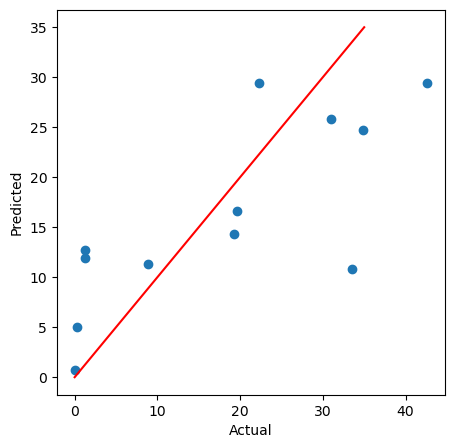

In [46]:
plt.figure(figsize=(5,5))
plt.scatter(y_val4, y_val_pred4)
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

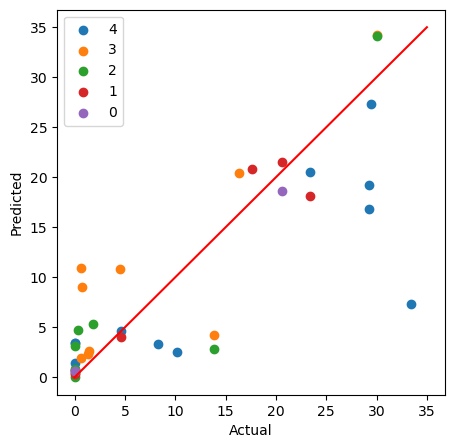

In [47]:
plt.figure(figsize=(5,5))
plt.scatter(y_test4, y_test_pred4, label='4')
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

Notice that the points with actual yields close to those seen in previous sets tend to predicted more accurately in this latter model. However newer points with actual yields further away from points we have already seen are very poorly predicted. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


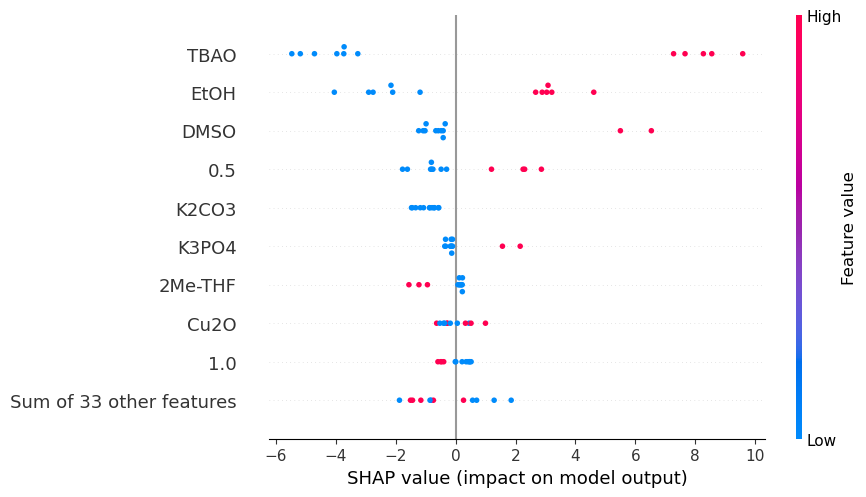

In [48]:
explainer = shap.Explainer(model, x_train4)
shap_values = explainer(x_val4, check_additivity=False)
shap.plots.beeswarm(shap_values)

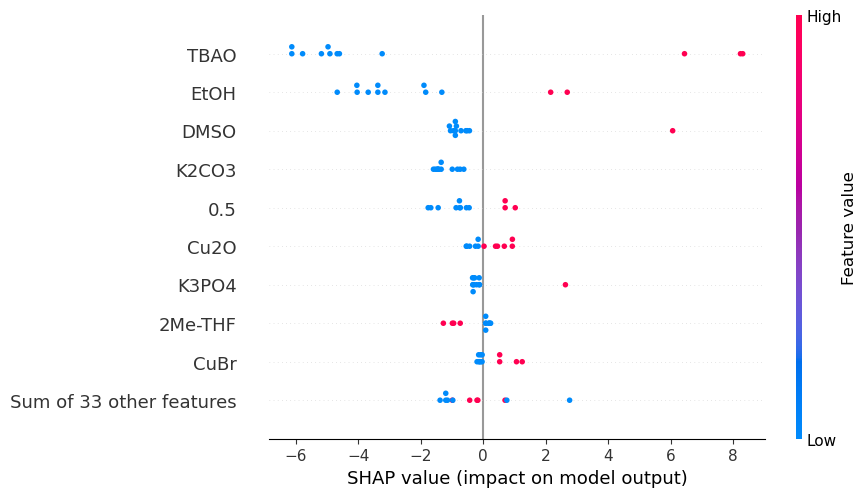

In [49]:
explainer = shap.Explainer(model, x_train4)
shap_values1 = explainer(x_test4, check_additivity=False)
shap.plots.beeswarm(shap_values1)

This set has 120 points which corresponds to 12 points in the validation set and the same for the test set. The SHAP values are starting to look closer to those we saw in models evaluating the entire data, however it is still missing some key features. Better and more diverse yields are seen in latter rounds, so we are expecting improvement.

## Round 0 + 1 + 2 + 3 + 4 + 5

In [50]:
rxns_df_x_5 = rxns_df_x.copy()
rxns_df_y_5 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_5)):
    if rxns_df_x_5['Round'][i] != 0:
        if rxns_df_x_5['Round'][i] != 1:
            if rxns_df_x_5['Round'][i] != 2:
                if rxns_df_x_5['Round'][i] != 3:
                    if rxns_df_x_5['Round'][i] != 4:
                        if rxns_df_x_5['Round'][i] != 5:
                            rxns_df_x_5 = rxns_df_x_5.drop([i], axis=0)
                            rxns_df_y_5 = rxns_df_y_5.drop([i], axis=0)
rxns_df_x_5= rxns_df_x_5.drop('Round', axis=1)

In [51]:
x_train5, x_temp, y_train5, y_temp = train_test_split(rxns_df_x_5, rxns_df_y_5, test_size=0.2, random_state=42)
x_val5, x_test5, y_val5, y_test5 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [52]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train5, y_train5)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [53]:
#validation
y_val_pred5 = model.predict(x_val5)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val5, y_val_pred5)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val5, y_val_pred5)
RMSE_val = np.sqrt(mean_squared_error(y_val5, y_val_pred5))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred5 = model.predict(x_test5)
accuracy_test = r2_score(y_test5, y_test_pred5)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test5, y_test_pred5)
RMSE_test = np.sqrt(mean_squared_error(y_test5, y_test_pred5))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.6364151809555944
Validation RMSE:7.936611855238627
Validation MAE:5.771807142857148
Test Set Accuracy with r2 : 0.5847390993251891
Test RMSE:9.813720880209845
Test MAE:8.575613333333333


There is an increase in r2 and a decrease in RMSE and MAE for both the validation and test sets in this model. We are now looking at more than 50% of the total data set !

Text(0.5, 0, 'Actual')

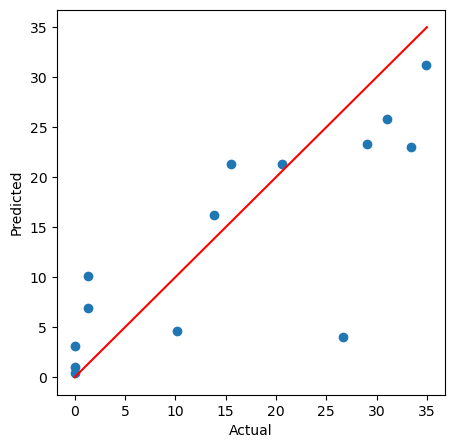

In [54]:
plt.figure(figsize=(5,5))
plt.scatter(y_val5, y_val_pred5)
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

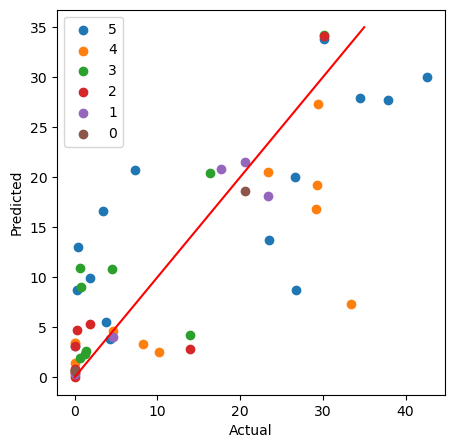

In [55]:
plt.figure(figsize=(5,5))
plt.scatter(y_test5, y_test_pred5, label='5')
plt.scatter(y_test4, y_test_pred4, label='4')
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,35], [0,35], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

The same observation as the one of the previous model can be made, though this one is slightly more accurate with its prediction of newer points.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


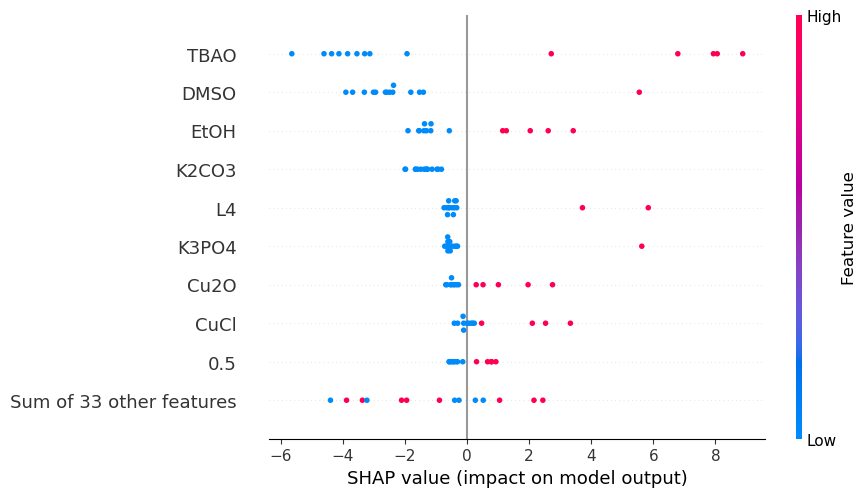

In [56]:
explainer = shap.Explainer(model, x_train5)
shap_values = explainer(x_val5, check_additivity=False)
shap.plots.beeswarm(shap_values)

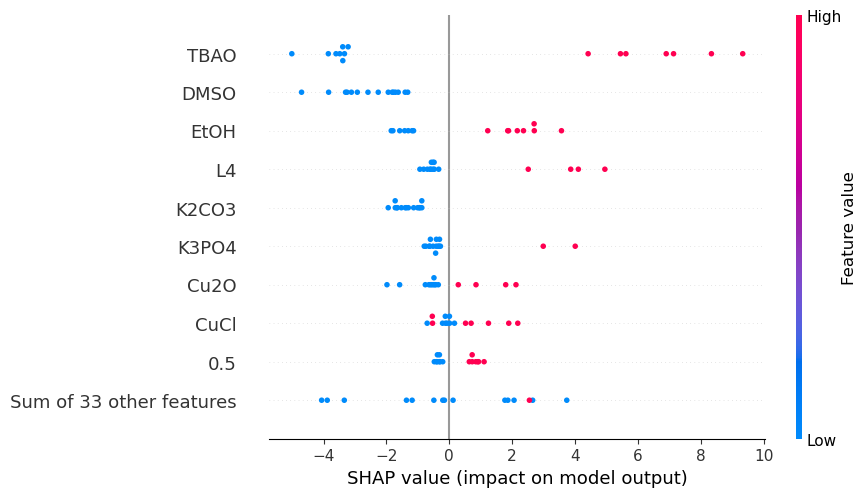

In [57]:
explainer = shap.Explainer(model, x_train5)
shap_values1 = explainer(x_test5, check_additivity=False)
shap.plots.beeswarm(shap_values1)

This set has 144 points, which corresponds to 14 points per validation and test sets. DMSO (the best solvent available for this reaction) is starting to show an increase in SHAP value as expected. The same can be said for the bases K2CO3, K3PO4 as well as the solvent EtOH. For now, the better ligands have not been identified yet, and neither has the temperature of reactions--both features with high SHAP values in models using the full data set.

## Round 0 + 1 + 2 + 3 + 4 + 5 + 6

In [58]:
rxns_df_x_6 = rxns_df_x.copy()
rxns_df_y_6 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_6)):
    if rxns_df_x_6['Round'][i] > 6:
        rxns_df_x_6 = rxns_df_x_6.drop([i], axis=0)
        rxns_df_y_6 = rxns_df_y_6.drop([i], axis=0)
rxns_df_x_6= rxns_df_x_6.drop('Round', axis=1)

In [59]:
x_train6, x_temp, y_train6, y_temp = train_test_split(rxns_df_x_6, rxns_df_y_6, test_size=0.2, random_state=42)
x_val6, x_test6, y_val6, y_test6 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [60]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train6, y_train6)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [61]:
#validation
y_val_pred6 = model.predict(x_val6)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val6, y_val_pred6)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val6, y_val_pred6)
RMSE_val = np.sqrt(mean_squared_error(y_val6, y_val_pred6))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred6 = model.predict(x_test6)
accuracy_test = r2_score(y_test6, y_test_pred6)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test6, y_test_pred6)
RMSE_test = np.sqrt(mean_squared_error(y_test6, y_test_pred6))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.6682699622073189
Validation RMSE:10.304757218734412
Validation MAE:7.362888235294119
Test Set Accuracy with r2 : -0.045016306739002365
Test RMSE:10.912078376249491
Test MAE:8.49121176470588


That's a strange accuracy for the test set. The validation set is improving however !

Text(0.5, 0, 'Actual')

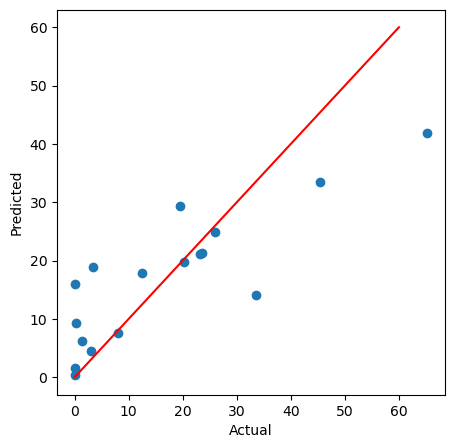

In [62]:
plt.figure(figsize=(5,5))
plt.scatter(y_val6, y_val_pred6)
plt.plot([0,60], [0,60], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

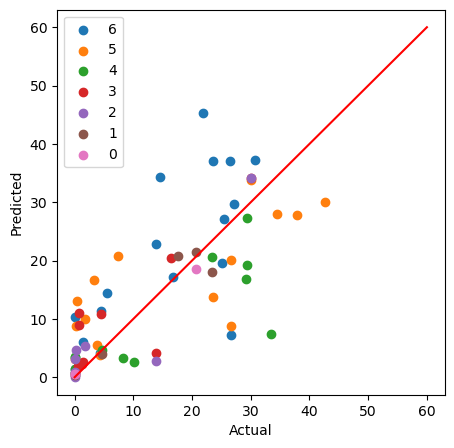

In [63]:
plt.figure(figsize=(5,5))
plt.scatter(y_test6, y_test_pred6, label='6')
plt.scatter(y_test5, y_test_pred5, label='5')
plt.scatter(y_test4, y_test_pred4, label='4')
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,60], [0,60], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

The test set for this model is very poorly predicted, especially in points with higher actual accuracies. The predictions are much higher than they should be. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


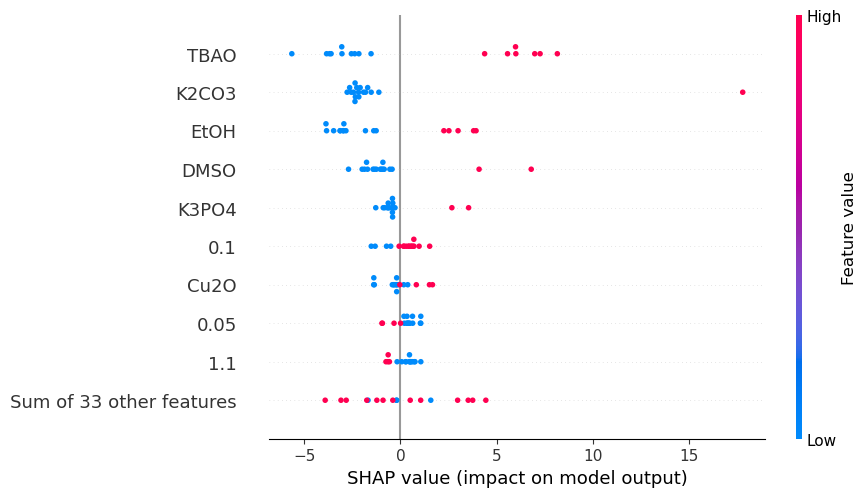

In [64]:
explainer = shap.Explainer(model, x_train6)
shap_values = explainer(x_val6, check_additivity=False)
shap.plots.beeswarm(shap_values)

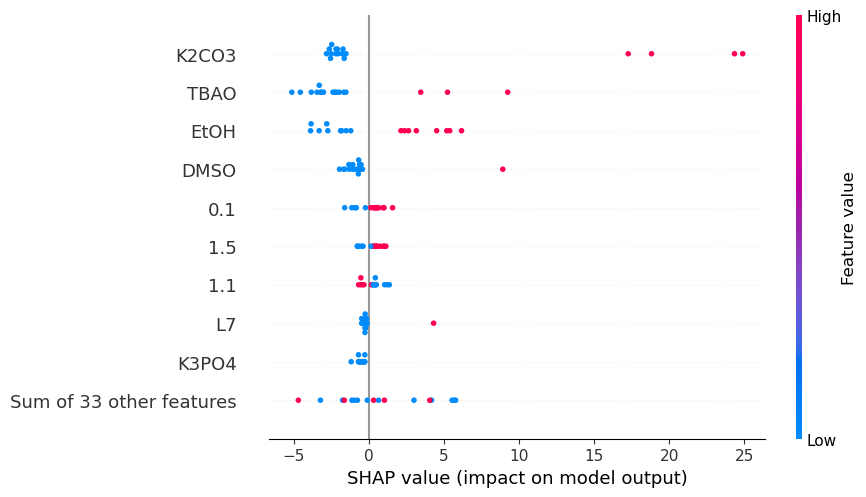

In [65]:
explainer = shap.Explainer(model, x_train6)
shap_values1 = explainer(x_test6, check_additivity=False)
shap.plots.beeswarm(shap_values1)

This set has 168 points, which leads to the distribution of 34 points between the test and validation sets. This model's SHAP values are quite different than those we have seen so far, introducing many equivalents (ligand, base, BnNH2) as being features with higher SHAP values. Its lower accuracy might therefore stem from an increase in features that it is unfamiliar with.

## Round 0 + 1 + 2 + 3 + 4 + 5 + 6 + 7

In [66]:
rxns_df_x_7 = rxns_df_x.copy()
rxns_df_y_7 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_7)):
    if rxns_df_x_7['Round'][i] > 7:
        rxns_df_x_7 = rxns_df_x_7.drop([i], axis=0)
        rxns_df_y_7 = rxns_df_y_7.drop([i], axis=0)
rxns_df_x_7= rxns_df_x_7.drop('Round', axis=1)

In [67]:
x_train7, x_temp, y_train7, y_temp = train_test_split(rxns_df_x_7, rxns_df_y_7, test_size=0.2, random_state=42)
x_val7, x_test7, y_val7, y_test7 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [68]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train7, y_train7)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [69]:
#validation
y_val_pred7 = model.predict(x_val7)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val7, y_val_pred7)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val7, y_val_pred7)
RMSE_val = np.sqrt(mean_squared_error(y_val7, y_val_pred7))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred7 = model.predict(x_test7)
accuracy_test = r2_score(y_test7, y_test_pred7)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test7, y_test_pred7)
RMSE_test = np.sqrt(mean_squared_error(y_test7, y_test_pred7))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.4768266357756866
Validation RMSE:11.294723191291352
Validation MAE:9.04132105263158
Test Set Accuracy with r2 : 0.629813553396966
Test RMSE:9.413708216770898
Test MAE:6.635445


The test set accuracy is much better, though the validation set accuracy has decreased again.

Text(0.5, 0, 'Actual')

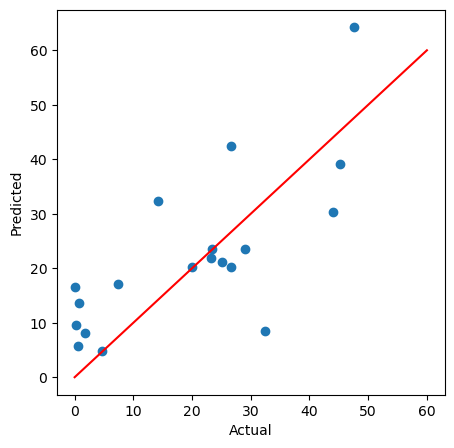

In [70]:
plt.figure(figsize=(5,5))
plt.scatter(y_val7, y_val_pred7)
plt.plot([0,60], [0,60], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

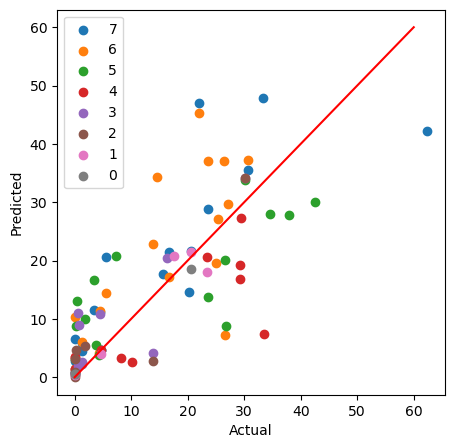

In [71]:
plt.figure(figsize=(5,5))
plt.scatter(y_test7, y_test_pred7, label='7')
plt.scatter(y_test6, y_test_pred6, label='6')
plt.scatter(y_test5, y_test_pred5, label='5')
plt.scatter(y_test4, y_test_pred4, label='4')
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,60], [0,60], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

This model, despite not having the best predictions, is definitely more accurate especially for lower yields than the previous model.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


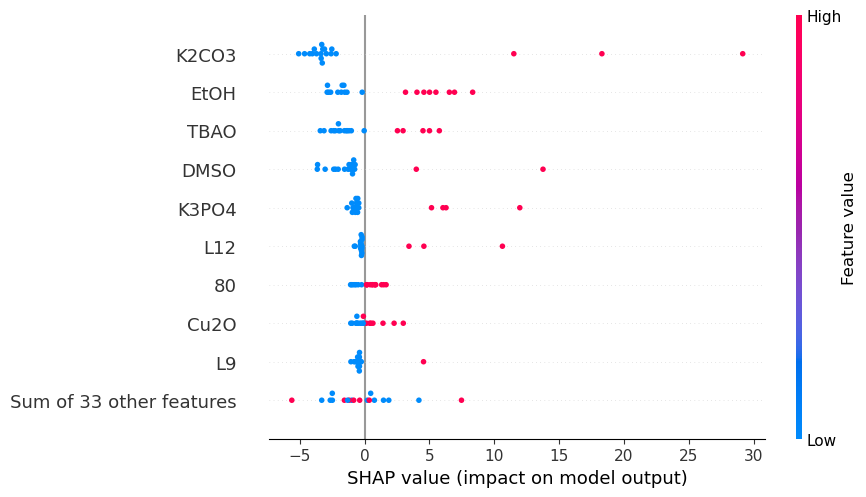

In [72]:
explainer = shap.Explainer(model, x_train7)
shap_values = explainer(x_val7, check_additivity=False)
shap.plots.beeswarm(shap_values)

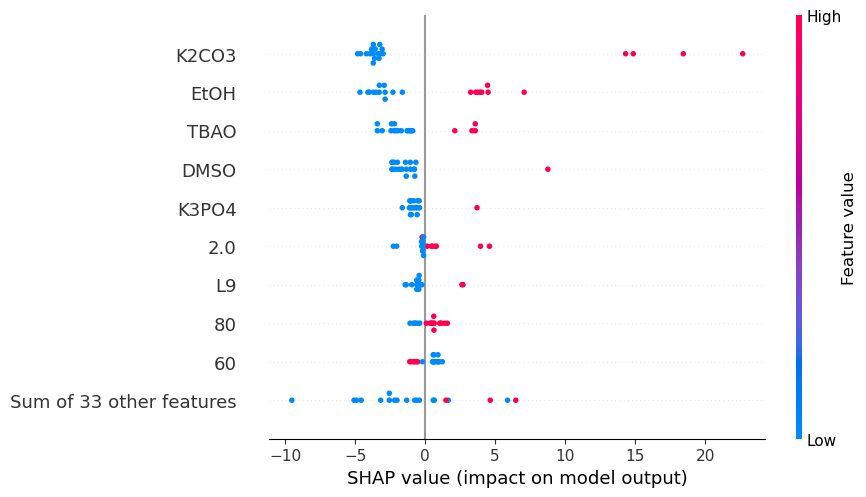

In [73]:
explainer = shap.Explainer(model, x_train7)
shap_values1 = explainer(x_test7, check_additivity=False)
shap.plots.beeswarm(shap_values1)

The set has 192 data points, which corresponds to 38 points distributed between the validation and test set. We can see that the SHAP value of K2CO3 and EtOH have finally surpassed TBAO's, and the temperatures are showing much higher SHAP values also. The 2.0 base equivalent is present now, we are starting to see more accurate feature importances in respect to the full set.

## Round 0 + 1 + 2 + 3 + 4 + 5 + 6 + 7 + 8

In [74]:
rxns_df_x_8 = rxns_df_x.copy()
rxns_df_y_8 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_8)):
    if rxns_df_x_8['Round'][i] > 8:
        rxns_df_x_8 = rxns_df_x_8.drop([i], axis=0)
        rxns_df_y_8 = rxns_df_y_8.drop([i], axis=0)
rxns_df_x_8= rxns_df_x_8.drop('Round', axis=1)

In [75]:
x_train8, x_temp, y_train8, y_temp = train_test_split(rxns_df_x_8, rxns_df_y_8, test_size=0.2, random_state=42)
x_val8, x_test8, y_val8, y_test8 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [76]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train8, y_train8)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [77]:
#validation
y_val_pred8 = model.predict(x_val8)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val8, y_val_pred8)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val8, y_val_pred8)
RMSE_val = np.sqrt(mean_squared_error(y_val8, y_val_pred8))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred8 = model.predict(x_test8)
accuracy_test = r2_score(y_test8, y_test_pred8)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test8, y_test_pred8)
RMSE_test = np.sqrt(mean_squared_error(y_test8, y_test_pred8))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.6722458059338097
Validation RMSE:13.432399717203452
Validation MAE:8.985318181818188
Test Set Accuracy with r2 : 0.07267726633456761
Test RMSE:18.633525038049996
Test MAE:14.439654545454538


Again, a strangely low test set accuracy while the validation set accuracy thrives.

Text(0.5, 0, 'Actual')

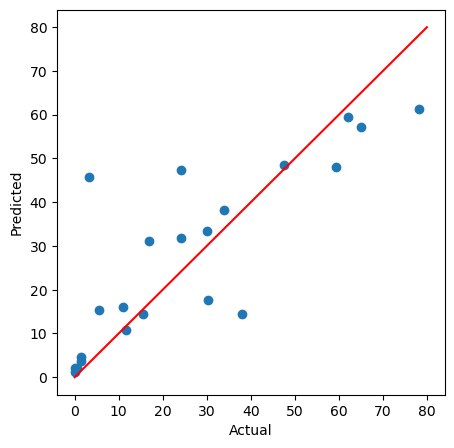

In [78]:
plt.figure(figsize=(5,5))
plt.scatter(y_val8, y_val_pred8)
plt.plot([0,80], [0,80], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

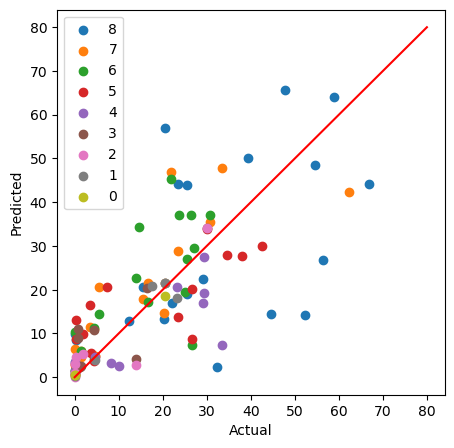

In [79]:
plt.figure(figsize=(5,5))
plt.scatter(y_test8, y_test_pred8, label='8')
plt.scatter(y_test7, y_test_pred7, label='7')
plt.scatter(y_test6, y_test_pred6, label='6')
plt.scatter(y_test5, y_test_pred5, label='5')
plt.scatter(y_test4, y_test_pred4, label='4')
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,80], [0,80], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

This model is very weak in its predictions of the test set, but quite accurate for the validation set. However we can see that it struggles most with points having actual yields between around 30 and 55, while its predictions are better for lower and higher yields. It has improved in the extremas.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


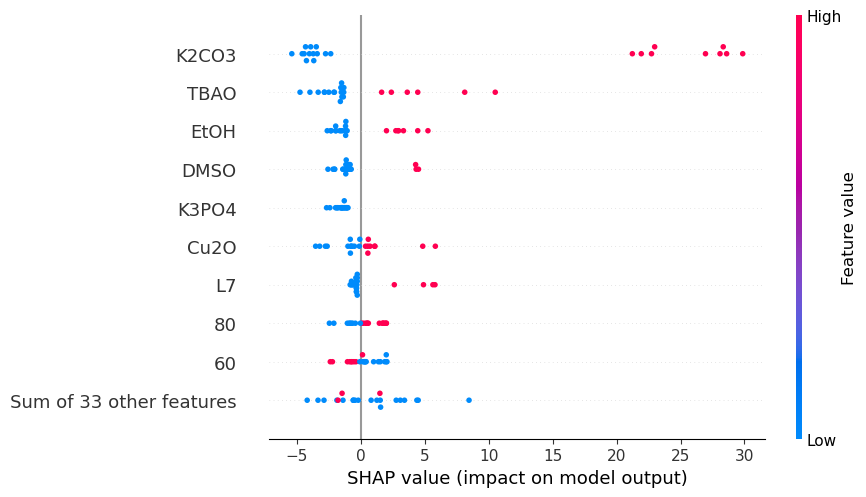

In [80]:
explainer = shap.Explainer(model, x_train8)
shap_values = explainer(x_val8, check_additivity=False)
shap.plots.beeswarm(shap_values)

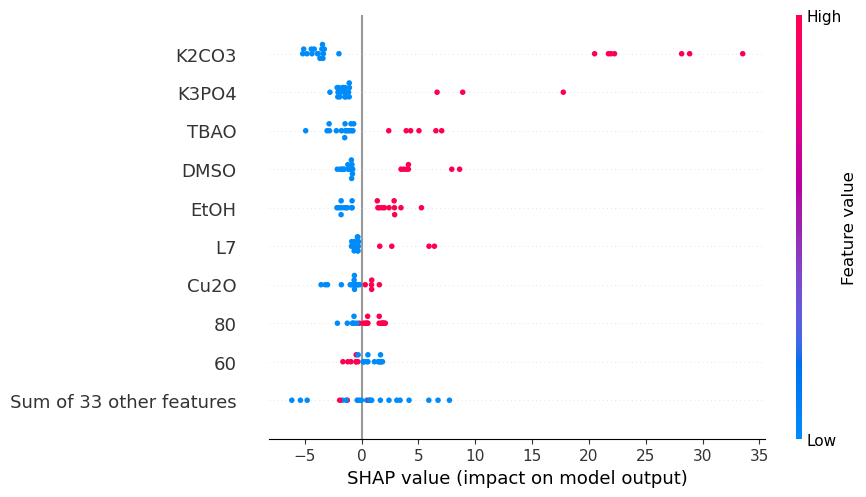

In [81]:
explainer = shap.Explainer(model, x_train8)
shap_values1 = explainer(x_test8, check_additivity=False)
shap.plots.beeswarm(shap_values1)

This set has 216 points, which gives 43 points to divide between the validation and test sets. The SHAP values are getting even closer to those we expect, with the most efficient bases K2CO3 and K3PO4 overtaking TBAO as points with higher yields are observed. Through rounds, we have already established that yields tend to increase--there is a significant increase between the first rounds, then the yield stalls around middle rounds before augmenting again in the latter ones. We are reaching the rounds with the highest yields now, which is why there are important changes in results to observe.

## Round 0 + 1 + 2 + 3 + 4 + 5 + 6 + 7 + 8 + 9

In [83]:
rxns_df_x_9 = rxns_df_x.copy()
rxns_df_y_9 = rxns_df_y.copy()
for i in range(0, len(rxns_df_x_9)):
    if rxns_df_x_9['Round'][i] == 10:
        rxns_df_x_9 = rxns_df_x_9.drop([i], axis=0)
        rxns_df_y_9 = rxns_df_y_9.drop([i], axis=0)
rxns_df_x_9= rxns_df_x_9.drop('Round', axis=1)

In [84]:
x_train9, x_temp, y_train9, y_temp = train_test_split(rxns_df_x_9, rxns_df_y_9, test_size=0.2, random_state=42)
x_val9, x_test9, y_val9, y_test9 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [85]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train9, y_train9)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [86]:
#validation
y_val_pred9 = model.predict(x_val9)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val9, y_val_pred9)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val9, y_val_pred9)
RMSE_val = np.sqrt(mean_squared_error(y_val9, y_val_pred9))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred9 = model.predict(x_test9)
accuracy_test = r2_score(y_test9, y_test_pred9)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test9, y_test_pred9)
RMSE_test = np.sqrt(mean_squared_error(y_test9, y_test_pred9))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.3941837473016835
Validation RMSE:14.946109718055956
Validation MAE:11.411016666666663
Test Set Accuracy with r2 : 0.16164751497194463
Test RMSE:16.570684844854785
Test MAE:11.07315


These are very weak accuracies for both sets.

Text(0.5, 0, 'Actual')

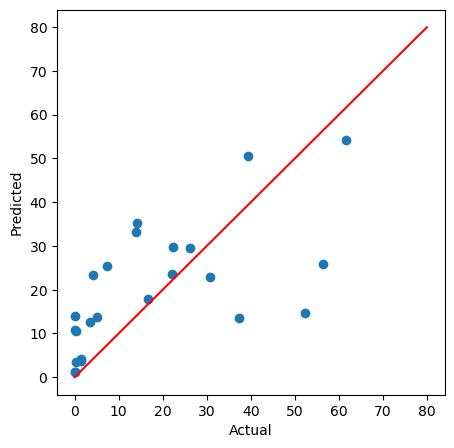

In [87]:
plt.figure(figsize=(5,5))
plt.scatter(y_val9, y_val_pred9)
plt.plot([0,80], [0,80], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

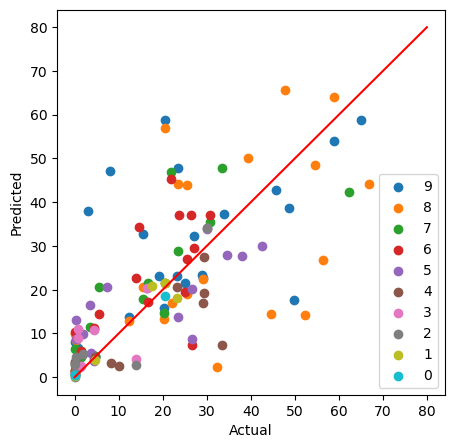

In [88]:
plt.figure(figsize=(5,5))
plt.scatter(y_test9, y_test_pred9, label='9')
plt.scatter(y_test8, y_test_pred8, label='8')
plt.scatter(y_test7, y_test_pred7, label='7')
plt.scatter(y_test6, y_test_pred6, label='6')
plt.scatter(y_test5, y_test_pred5, label='5')
plt.scatter(y_test4, y_test_pred4, label='4')
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,80], [0,80], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

The accuracy is visually seen to degrade as well in these two graphs. As the model is exposed to newer, higher yields, it seems to struggle even more with points having "medium" yields.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


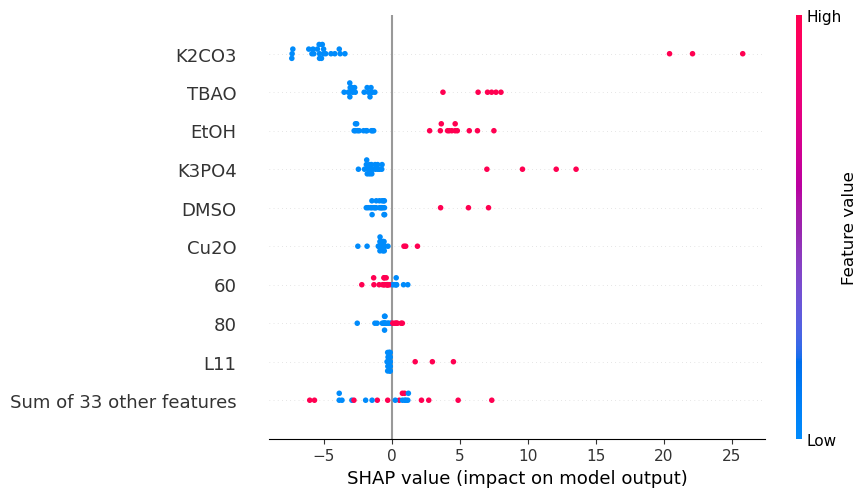

In [89]:
explainer = shap.Explainer(model, x_train9)
shap_values = explainer(x_val9, check_additivity=False)
shap.plots.beeswarm(shap_values)

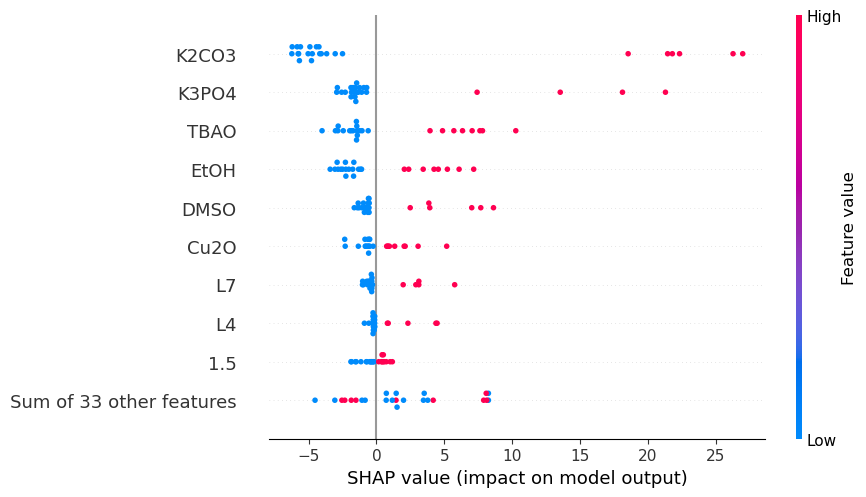

In [90]:
explainer = shap.Explainer(model, x_train9)
shap_values1 = explainer(x_test9, check_additivity=False)
shap.plots.beeswarm(shap_values1)

This set has 240 points, which corresponds to 24 points per validation and test set. The SHAP values of the test set are closer to our expectations than those of the validation set, most of the best features have been correctly identified. However, although it almost has the full data set, this model is very weak in its predictions.

## Full dataset

In [91]:
rxns_df_x_10 = rxns_df_x.copy()
rxns_df_y_10 = rxns_df_y.copy()
rxns_df_x_10= rxns_df_x_10.drop('Round', axis=1)

In [92]:
x_train10, x_temp, y_train10, y_temp = train_test_split(rxns_df_x_10, rxns_df_y_10, test_size=0.2, random_state=42)
x_val10, x_test10, y_val10, y_test10 = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [93]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train10, y_train10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [94]:
#validation
y_val_pred10 = model.predict(x_val10)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val10, y_val_pred10)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val10, y_val_pred10)
RMSE_val = np.sqrt(mean_squared_error(y_val10, y_val_pred10))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred10 = model.predict(x_test10)
accuracy_test = r2_score(y_test10, y_test_pred10)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test10, y_test_pred10)
RMSE_test = np.sqrt(mean_squared_error(y_test10, y_test_pred10))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.7448681933302931
Validation RMSE:11.322791103379462
Validation MAE:8.461923076923076
Test Set Accuracy with r2 : 0.5411712063072343
Test RMSE:13.452722537312876
Test MAE:9.516355555555549


The accuracy of the validation set is the highest we have seen so far, though the test set is significantly less well predicted.

Text(0.5, 0, 'Actual')

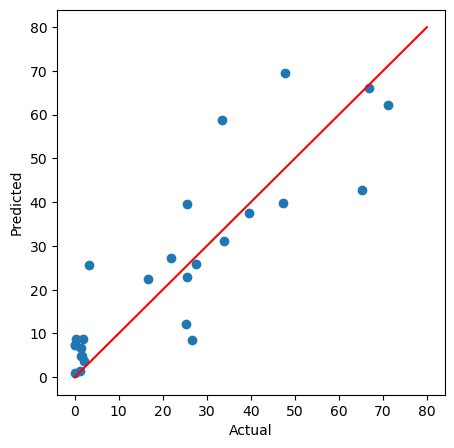

In [95]:
plt.figure(figsize=(5,5))
plt.scatter(y_val10, y_val_pred10)
plt.plot([0,80], [0,80], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

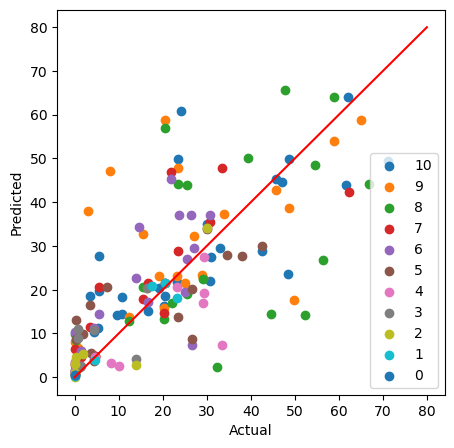

In [96]:
plt.figure(figsize=(5,5))
plt.scatter(y_test10, y_test_pred10, label='10')
plt.scatter(y_test9, y_test_pred9, label='9')
plt.scatter(y_test8, y_test_pred8, label='8')
plt.scatter(y_test7, y_test_pred7, label='7')
plt.scatter(y_test6, y_test_pred6, label='6')
plt.scatter(y_test5, y_test_pred5, label='5')
plt.scatter(y_test4, y_test_pred4, label='4')
plt.scatter(y_test3,y_test_pred3, label="3")
plt.scatter(y_test2, y_test_pred2, label="2")
plt.scatter(y_test1,y_test_pred1, label="1")
plt.scatter(y_test0,y_test_pred0, label="0")
plt.plot([0,80], [0,80], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()

Overall, this model is definitely the most accurate out of the latter ones (7, 8, 9...). We would have to see how well the earliest models with higher accuracy perform with validation and test sets that include yields with a wider range.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


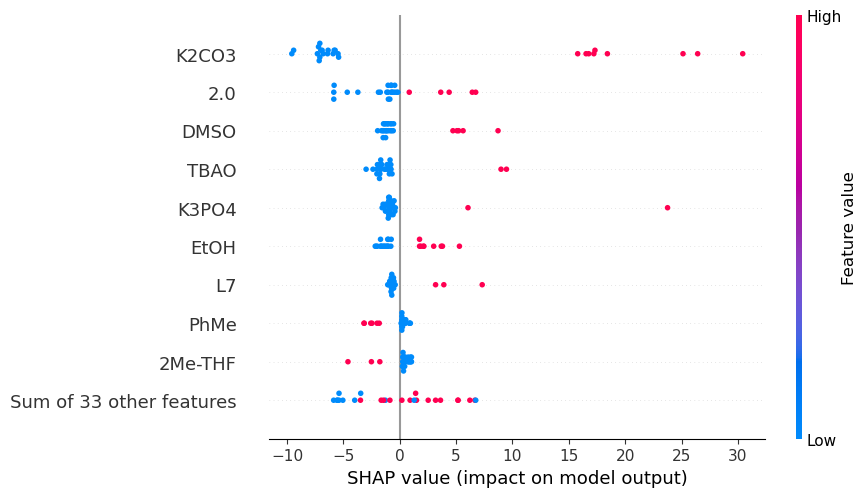

In [97]:
explainer = shap.Explainer(model, x_train10)
shap_values = explainer(x_val10, check_additivity=False)
shap.plots.beeswarm(shap_values)

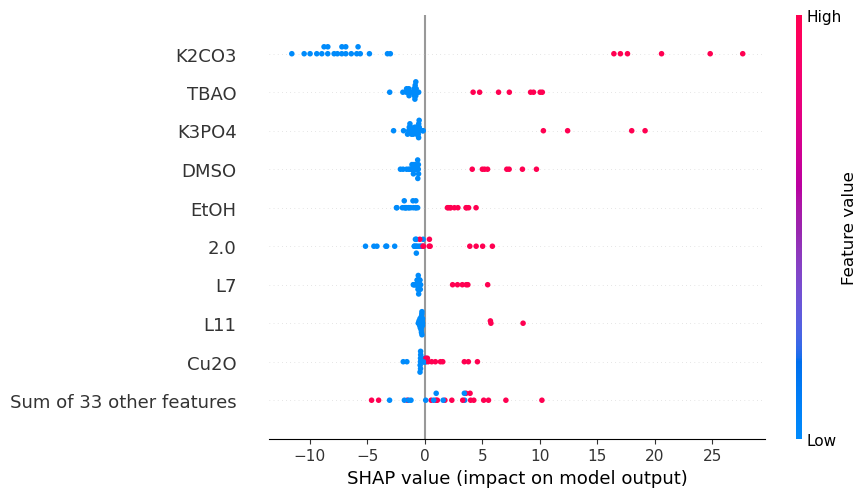

In [98]:
explainer = shap.Explainer(model, x_train10)
shap_values1 = explainer(x_test10, check_additivity=False)
shap.plots.beeswarm(shap_values1)

These final SHAP values are qualitatively satisfactory. One of the most jarring details might be the absence of CuBr, which is the best Cu source overall, as well as the temperatures. Otherwise, the bases having most of the higher SHAP values makes sense in respect to our expectations.

## Some comparisons

In [105]:
data_nb = [i for i in range(24,288,24)]
val_accuracy = [0.0,0.3432842631799905,0.6539420991044583,0.5201442883005029,0.5487131780210539,0.6364151809555944,
                0.6682699622073189,0.4768266357756866,0.6722458059338097,0.3941837473016835,0.7448681933302931]
test_accuracy = [0.9830184895848637,0.9087262725908675,0.783112793210553,0.6175335090884609,0.5487131780210539,
                 0.5847390993251891,-0.045016306739002365,0.629813553396966,0.07267726633456761,0.16164751497194463,
                 0.5411712063072343]

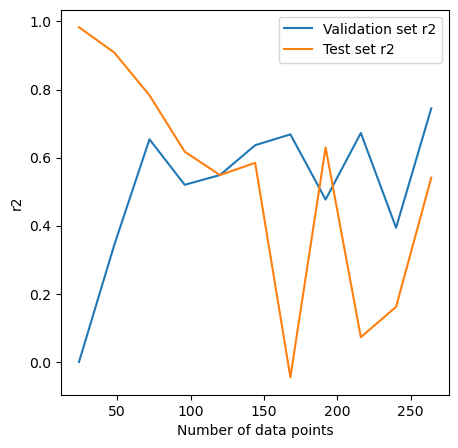

In [103]:
plt.figure(figsize=(5,5))
plt.plot(data_nb, val_accuracy, label='Validation set r2')
plt.plot(data_nb, test_accuracy, label='Test set r2')
plt.ylabel('r2')
plt.xlabel('Number of data points')
plt.legend()

The highest validation set accuracy is from the full dataset, while the highest test set accuracy is from the very first set.

In [107]:
val_RMSE = [0.6860488211490491,9.456507469673971,7.4705992907434835,8.434612500464969,9.89180324827076,
            7.936611855238627,10.304757218734412,11.294723191291352,13.432399717203452,14.946109718055956,11.322791103379462]
val_MAE = [0.67825,8.235919999999979,5.226514285714283,5.006829999999991,8.014041666666664,5.771807142857148,
           7.362888235294119,9.04132105263158,8.985318181818188,11.411016666666663,8.461923076923076]

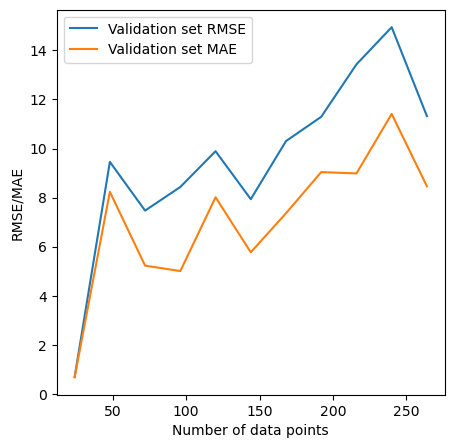

In [108]:
plt.figure(figsize=(5,5))
plt.plot(data_nb, val_RMSE, label='Validation set RMSE')
plt.plot(data_nb, val_MAE, label='Validation set MAE')
plt.ylabel('RMSE/MAE')
plt.xlabel('Number of data points')
plt.legend()